In [9]:
#Importing Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import shap
import sklearn
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import log_loss
from statistics import mean
import scipy as sp
import scipy.stats

from hyperopt.pyll.base import scope
from hyperopt import hp, fmin, tpe, Trials
from hyperopt import space_eval

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
sns.set_palette("coolwarm_r", 4)

### データの読み込み

In [11]:
#Reading the data files

train = pd.read_csv(r"C:\Users\NDO00\OneDrive\デスクトップ\MI\mi_book\e-commerce\train.csv",index_col = 'id')
test = pd.read_csv(r"C:\Users\NDO00\OneDrive\デスクトップ\MI\mi_book\e-commerce\test.csv",index_col = 'id')
sample = pd.read_csv(r"C:\Users\NDO00\OneDrive\デスクトップ\MI\mi_book\e-commerce\test.csv")

## データセット準備

In [18]:
#保存したパラメータを読み込むための関数
def pickle_load(path):
    with open(path,mode='rb') as f:
        data = pickle.load(f)
        return data

In [19]:
#part2のnotebookで見つけたベストな特徴量の組み合わせを読み込む
feats_m = pickle_load("feats_m.txt.")
X_train_m = train[feats_m]
X_test_m = test[feats_m]
Y_train = train['target'].copy()


In [20]:
#part2のnotebookで見つけたベストな特徴量の組み合わせの訓練されたモデルの読み込み
with open('lgbm_tuned_m.pickle', 'rb') as f:
    lgbm_tuned_m = pickle.load(f)

print(lgbm_tuned_m)

LGBMClassifier(colsample_bytree=0.647029449963611, learning_rate=0.02,
               max_depth=7, metric='multi_logloss', min_child_samples=75,
               min_child_weight=0, n_estimators=2000, num_class=4, num_leaves=8,
               random_state=42, reg_alpha=0.7272793239132271,
               reg_lambda=0.5369919183467708, subsample=0.7853386927113121)


# SHAPを使った分析結果の説明

In [21]:
#Fitting the SHAP on our model and training data


explainer = shap.TreeExplainer(model=lgbm_tuned_m,data=X_train_m,feature_perturbation="interventional",)
#shap値を計算(３時間はかかる)
shap_values = explainer.shap_values(X_train_m)

100%|===================| 399995/400000 [261:41<00:00]         

In [22]:
#各クラス、各インスタンスごとに計算されたSHAP値を保存
with open('shap_values.text', 'wb') as g1:
    pickle.dump(shap_values,g1)

In [23]:
sh=pickle_load("shap_values.text.")
print(sh)

[array([[ 0.00824272, -0.00727405, -0.0544108 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00054939, -0.01808471,  0.0104979 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.0024064 , -0.00722811,  0.01383575, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00665428,  0.00789732,  0.00332489, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00613381, -0.00989508, -0.00376394, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00735996,  0.05405411,  0.00499478, ...,  0.        ,
         0.        ,  0.        ]]), array([[-0.05538452,  0.01544227, -0.04181401, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05195711, -0.01150705,  0.02127141, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03453768, -0.02928167, -0.13816774, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.0573371 , -0.02369921,  0.03566892, ...,  0.        ,
        

## SHAPによる特徴量重要度

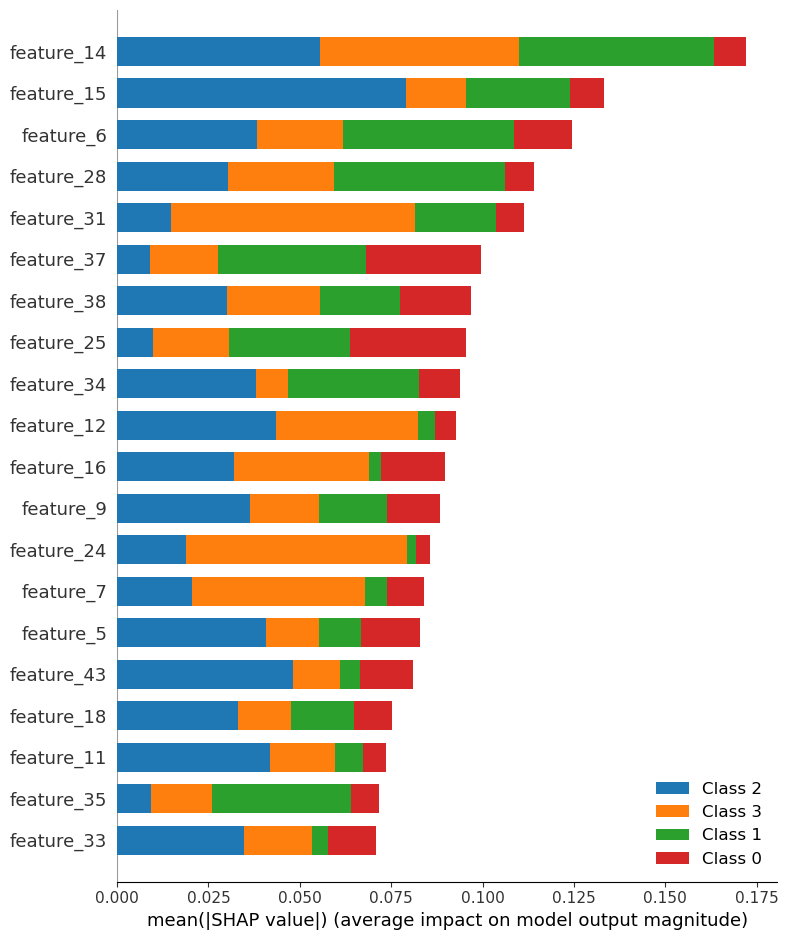

In [31]:
shap.summary_plot(shap_values, X_train_m, color=plt.get_cmap("tab10"))

## 各特徴量での貢献度の分布(Class_0)

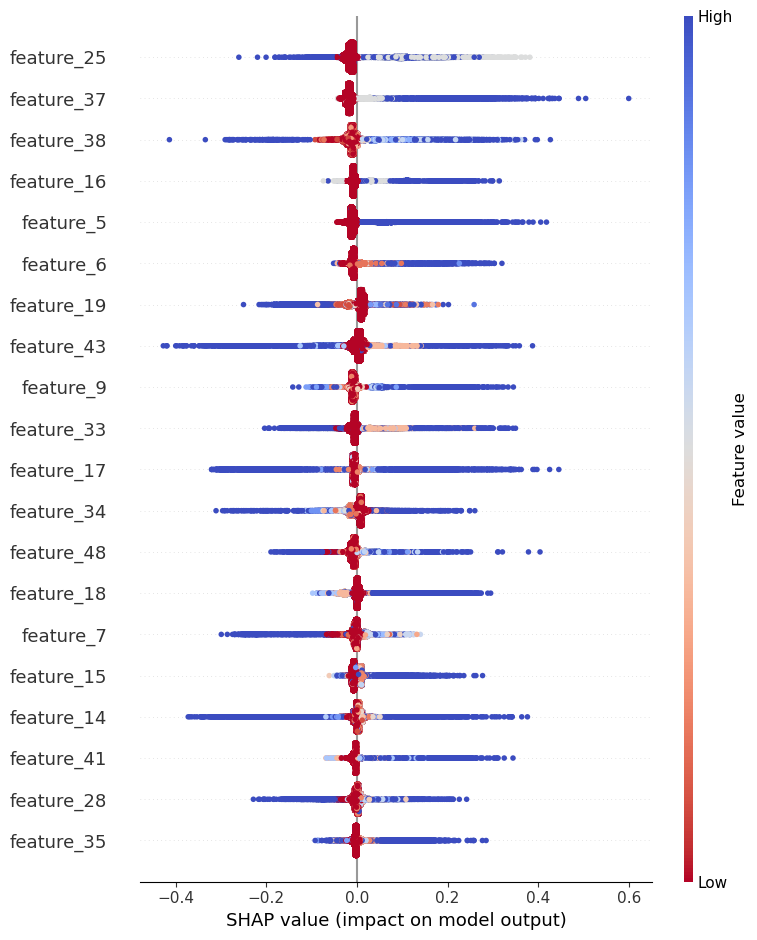

In [25]:
shap.summary_plot(shap_values[0], X_train_m, show = False, cmap = 'coolwarm_r')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

特徴量重要度の上位３つについて

・feature_25はは正と負の両方向に貢献度が広く分布している。

・ feature_37は特徴量が大きいと貢献度が正に大きい。貢献度は正のものが多い。

・ feature_38は正と負の両方向に貢献度が広く分布している


## 各特徴量での貢献度の分布(Class_1)

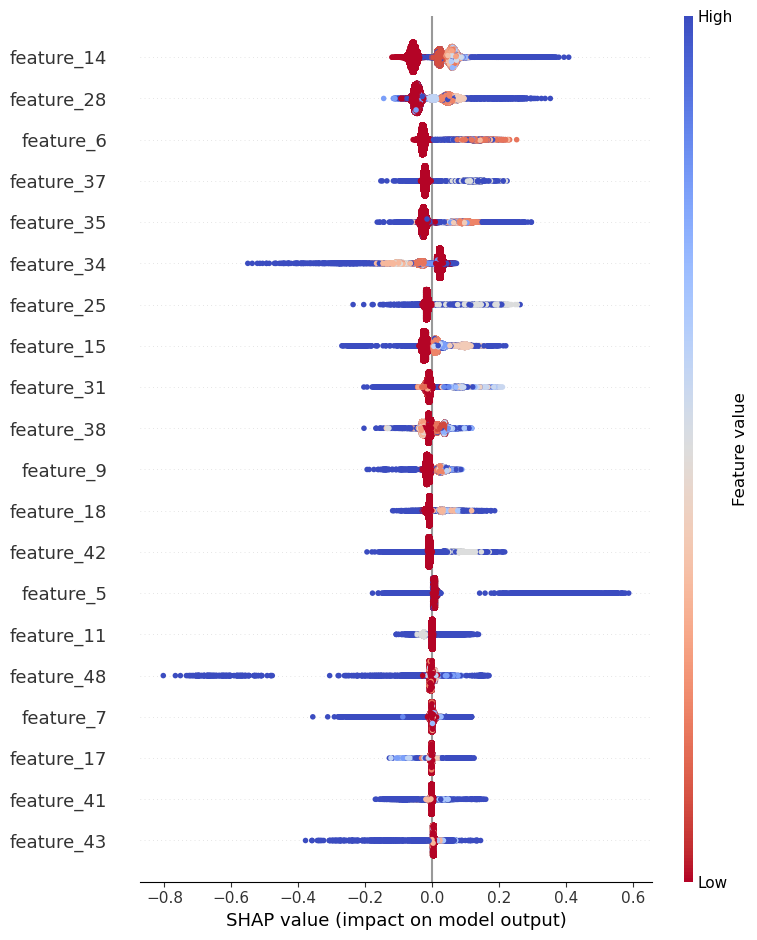

In [27]:
shap.summary_plot(shap_values[1], X_train_m, show = False, cmap = 'coolwarm_r')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

特徴量重要度の上位３つについて

・feature_14はは特徴量が大きいと貢献度が正に大きい。貢献度は正のものが多い。

・ feature_28は特徴量が大きいと貢献度が正に大きい。貢献度は正のものが多い。

・ feature_6は貢献度が正のものが多い。


## 各特徴量での貢献度の分布(Class_2)

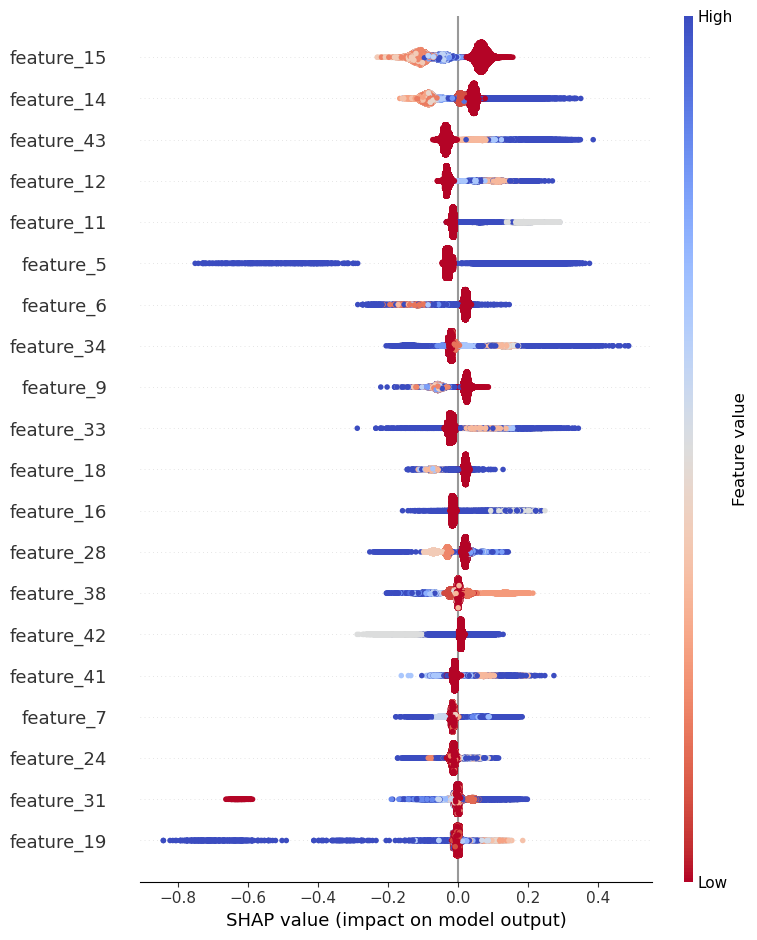

In [28]:
shap.summary_plot(shap_values[2], X_train_m, show = False, cmap = 'coolwarm_r')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

特徴量重要度の上位３つについて

・feature_15は貢献度は0付近に分布している。
Feature_value=0の多数のデータが正の貢献度を持つため、特徴量重要度が1位となっている。

・ feature_14は特徴量が大きいと貢献度が正に大きい。貢献度は正のものが多い。

・ feature_43は貢献度が正のものが多い。


## 各特徴量での貢献度の分布(Class_3)

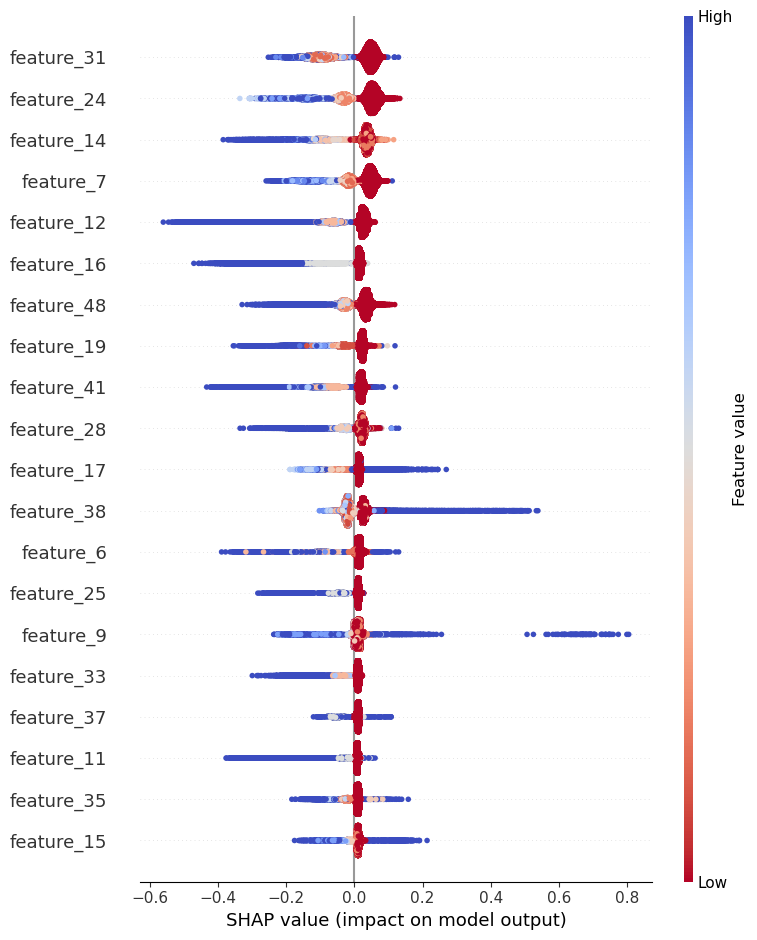

In [29]:
shap.summary_plot(shap_values[3], X_train_m, show = False, cmap = 'coolwarm_r')
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

特徴量重要度の上位３つについて

・feature_31は貢献度は0付近に分布している。
Feature_value=0の多数のデータが正の貢献度を持つため、特徴量重要度が1位となっている。

・feature_24は貢献度は0付近に分布している。
Feature_value=0の多数のデータが正の貢献度を持つため、特徴量重要度が1位となっている。

・feature_14は貢献度は0付近に分布している。
Feature_value=0の多数のデータが正の貢献度を持つため、特徴量重要度が1位となっている。
